In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, regularizers

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

In [3]:
data = pd.read_csv('hotel_bookings.csv')
data_cln = data.fillna({'children': 0.0, 'country': 'Unknown', 'agent':0, 'company': 0})
data_cln['meal'].replace('Undefined', 'SC', inplace = True)

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])



In [4]:
resort_data = data_cln[data_cln.hotel == 'Resort Hotel']
city_data = data_cln[data_cln.hotel == 'City Hotel']

In [5]:
def test_model_1():
    inputs = keras.Input(shape=(62, 1,), dtype = "float32")
    x = layers.Bidirectional(layers.LSTM(256, return_sequences = True))(inputs)
    #x = layers.Bidirectional(layers.LSTM(128, return_sequences = True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences = True))(x)
    x = layers.Flatten()(x)
    # outputs = layers.Reshape((100, 256, 1))(x)
    outputs = layers.Dense(1, activation='sigmoid',
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
    model = keras.Model(inputs, outputs)
    # model.summary()

    model.compile("adam", "binary_crossentropy", metrics=["accuracy", "AUC"])
    return model

In [6]:
tmp = test_model_1()

In [ ]:
# 10 fold
kfolds = 10 # 
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

x = data_cln.drop(["is_canceled"], axis=1)[features]
y = data_cln["is_canceled"].to_numpy()

x = preprocessor.fit_transform(x)

train_X = x[data_cln.hotel == 'Resort Hotel']
train_Y = y[data_cln.hotel == 'Resort Hotel']

test_X = x[data_cln.hotel == 'City Hotel']
test_Y = y[data_cln.hotel == 'City Hotel']

train_X = train_X.reshape((-1, 62, 1))
test_X = test_X.reshape((-1, 62, 1))
result = []
rc_result = []

for train_index, test_index in split.split(train_Y):
    train_x = train_X[train_index]
    train_y = train_Y[train_index]
    
    test_x = train_X[test_index]
    test_y = train_Y[test_index]
    
    model = test_model_1()
    
    history = model.fit(train_x, train_y, batch_size=64, epochs=30, verbose = 2)
    pred_y = model.predict(test_x)
    result.append({'pred': pred_y, 'test': test_y})
    pred_y = model.predict(test_X)
    rc_result.append({'pred': pred_y, 'test': test_Y})

Epoch 1/30
564/564 - 34s - loss: 0.4782 - accuracy: 0.7747 - auc: 0.7822
Epoch 2/30
564/564 - 34s - loss: 0.4075 - accuracy: 0.8116 - auc: 0.8513
Epoch 3/30


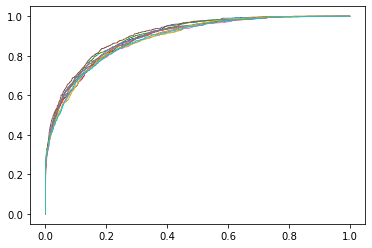

In [17]:
total_accuracy = []
total_f1 = []
total_pre = []
total_recall = []
total_auc = []
for i in range(10):
    pred = result[i]['pred']
    test = result[i]['test']
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    total_auc.append(roc_auc)
    plt.plot(fpr, tpr, lw=0.8)
    t_acc = []
    t_f1 = []
    t_pre = []
    t_rec = []
    for t in np.arange(0,1,0.05):
        p_val = np.zeros(pred.shape)
        p_val[pred > t] = 1
        t_acc.append(accuracy_score(test, p_val))
        t_f1.append(f1_score(test, p_val))
        t_pre.append(precision_score(test, p_val))
        t_rec.append(recall_score(test, p_val)) 
    total_accuracy.append(np.max(t_acc))
    total_f1.append(np.max(t_f1))
    total_pre.append(np.max(t_pre))
    total_recall.append(np.max(t_rec)) 
    
plt.savefig('resortEncodeDNN.png')

In [18]:
total_res = {'auc':total_auc, 'acc': total_accuracy, 'f1': total_f1,
            'pre': total_pre, 'recall': total_recall}

In [19]:
# total
for k, v in total_res.items():
    print(k, '\t', min(v), max(v), np.average(v))

auc 	 0.8841744382105717 0.9074165084053433 0.8940691251322704
acc 	 0.8317523714428358 0.8499750374438343 0.841962056914628
f1 	 0.6902887139107611 0.7251461988304093 0.7039932864245126
pre 	 0.9691358024691358 0.9928057553956835 0.978732390778705
recall 	 1.0 1.0 1.0


In [20]:
total_res

{'auc': [0.8992258853594388,
  0.8926885377450466,
  0.9010757644166855,
  0.8914445444014791,
  0.8964864230745166,
  0.9074165084053433,
  0.8841744382105717,
  0.8948183547737076,
  0.887092531259395,
  0.8862682636765206],
 'acc': [0.8472291562656016,
  0.8412381427858213,
  0.8474787818272591,
  0.836245631552671,
  0.8464802795806291,
  0.8499750374438343,
  0.836245631552671,
  0.8442336495257114,
  0.8317523714428358,
  0.8387418871692461],
 'f1': [0.7004149377593362,
  0.6973406500633178,
  0.7128630705394191,
  0.7061668681983072,
  0.7085318319618882,
  0.7251461988304093,
  0.6958424507658644,
  0.7045951859956237,
  0.6987429562201994,
  0.6902887139107611],
 'pre': [0.9754601226993865,
  0.9717868338557993,
  0.976027397260274,
  0.9691358024691358,
  0.9928057553956835,
  0.9866220735785953,
  0.9761904761904762,
  0.9790209790209791,
  0.9743589743589743,
  0.9859154929577465],
 'recall': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

In [21]:
np.average(total_res['auc'])

0.8940691251322704

In [22]:
np.average(total_res['acc'])

0.841962056914628

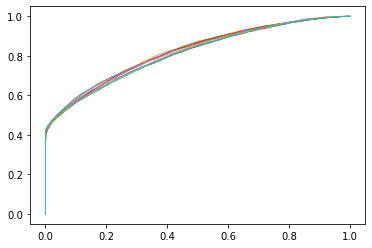

In [23]:
total_accuracy = []
total_f1 = []
total_pre = []
total_recall = []
total_auc = []
for i in range(10):
    pred = rc_result[i]['pred']
    test = rc_result[i]['test']
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    total_auc.append(roc_auc)
    plt.plot(fpr, tpr, lw=0.8)
    t_acc = []
    t_f1 = []
    t_pre = []
    t_rec = []
    for t in np.arange(0,1,0.05):
        p_val = np.zeros(pred.shape)
        p_val[pred > t] = 1
        t_acc.append(accuracy_score(test, p_val))
        t_f1.append(f1_score(test, p_val))
        t_pre.append(precision_score(test, p_val))
        t_rec.append(recall_score(test, p_val)) 
    total_accuracy.append(np.max(t_acc))
    total_f1.append(np.max(t_f1))
    total_pre.append(np.max(t_pre))
    total_recall.append(np.max(t_rec)) 
    
plt.savefig('rcEncodeDNN.png')

In [24]:
rc_res = {'auc':total_auc, 'acc': total_accuracy, 'f1': total_f1,
            'pre': total_pre, 'recall': total_recall}

In [25]:
# total
for k, v in rc_res.items():
    print(k, '\t', min(v), max(v), np.average(v))

auc 	 0.808684420523061 0.8224451908845815 0.8163521327477955
acc 	 0.7635698978948695 0.7704021177360393 0.7659611748392788
f1 	 0.6768896538103434 0.695077979060776 0.686997605731025
pre 	 0.9154416020372729 0.9826198688036789 0.9489318341430296
recall 	 1.0 1.0 1.0


In [26]:
rc_res

{'auc': [0.8180152908062633,
  0.8224451908845815,
  0.8220156629546042,
  0.8201079328473324,
  0.8218242566115426,
  0.809357467235176,
  0.815168320972678,
  0.808684420523061,
  0.8131726085453398,
  0.8127301760973775],
 'acc': [0.7643640489096181,
  0.7660153787974284,
  0.7704021177360393,
  0.76541031135762,
  0.7695953611496281,
  0.7638346148997857,
  0.7643640489096181,
  0.7635698978948695,
  0.7640993319047019,
  0.7679566368334804],
 'f1': [0.6881652497562182,
  0.695077979060776,
  0.6940446162908366,
  0.69022987685678,
  0.693065988146207,
  0.6815986073837673,
  0.6907867301304267,
  0.6768896538103434,
  0.6800505015469567,
  0.680066854327938],
 'pre': [0.9558392496580473,
  0.9154416020372729,
  0.9403965454324291,
  0.9522660911514536,
  0.946179604261796,
  0.9582366589327146,
  0.9455093960153353,
  0.9647220226040374,
  0.928107302533532,
  0.9826198688036789],
 'recall': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}